# Table of Contents
<p>
<div class="lev1"><a href="#Data-from-the-Web"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data from the Web</a></div>
<div class="lev1"><a href="#Getting-the-data"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the data</a></div>
<div class="lev2"><a href="#Requesting-ISA-form"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Requesting ISA form</a></div>
<div class="lev2"><a href="#Finding-form-IDs"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Finding form IDs</a></div>
<div class="lev2"><a href="#Filtering-and-getting-the-data"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Filtering and getting the data</a></div>
<div class="lev2"><a href="#Extracting-data-from-the-result-page"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extracting data from the result page</a></div>
<div class="lev1"><a href="#Treating-data"><span class="toc-item-num">3&nbsp;&nbsp;</span>Treating data</a></div>

<div class="lev2"><a href="#Getting-start-year"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Getting start year</a></div>
<div class="lev2"><a href="#Getting-end-year"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Getting end year</a></div>
<div class="lev3"><a href="#Treating-Bachelor-5-Data"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Treating Bachelor 5 Data</a></div>
<div class="lev3"><a href="#Treating-Bachelor-6-Data"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Treating Bachelor 6 Data</a></div>
<div class="lev2"><a href="#Obtain-end-year"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Obtain end year</a></div>
<div class="lev2"><a href="#Concatenate-start-and-end-year"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Concatenate start and end year</a></div>
<div class="lev2"><a href="#Compute-Bachelor-duration"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Compute Bachelor duration</a></div>
<div class="lev2"><a href="#Partition-men-and-women"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Partition men and women</a></div>
<div class="lev2"><a href="#Compute-mean-for-each-group"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Compute mean for each group</a></div>
<div class="lev2"><a href="#Gender-group-description"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Gender group description</a></div>
<div class="lev2"><a href="#Duration-according-to-gender"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Duration according to gender</a></div>


<div class="lev1"><a href="#Statistical-test-and-conclusion"><span class="toc-item-num">4&nbsp;&nbsp;</span> Statistical test and conclusion</a></div>




# Data from the Web

In this homework we will extract interesting information from IS-Academia, the educational portal of EPFL. Specifically, we will focus on the part that allows public access to academic data. The list of registered students by section and semester is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need. On this form you can select the data to download based on different criteria (e.g., year, semester, etc.)

You are not allowed to download manually all the tables -- rather you have to understand what parameters the server accepts, and generate accordingly the HTTP requests. For this task, Postman with the Interceptor extension can help you greatly. I recommend you to watch this brief tutorial to understand quickly how to use it. Your code in the iPython Notebook should not contain any hardcoded URL. To fetch the content from the IS-Academia server, you can use the Requests library with a Base URL, but all the other form parameters should be extracted from the HTML with BeautifulSoup. You can choose to download Excel or HTML files -- they both have pros and cons, as you will find out after a quick check. You can also choose to download data at different granularities (e.g., per semester, per year, etc.) but I recommend you not to download all the data in one shot because 1) the requests are likely to timeout and 2) we will overload the IS-Academia server.


In [151]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import requests
import re
import scipy.stats as stats
from bs4 import BeautifulSoup
sns.set_context('notebook')

# Getting the data

## Finding ISA form 

The first part of the job in order to get the data is to get the parameters required to get the data we want.

In this purpose, we first do a get request on the ISA form with the link <http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247>.

We also use BeautifulSoup on the resulting html response in order to parse it later.

In [6]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
r.headers['content-type']
html_doc = r.text
isaForm = BeautifulSoup(html_doc, 'html.parser')

## Finding form IDs

Now that we've got the form's html code, we need to know which values of the form are used to filter and displayed the desired data. The values we're interested in are 'unité académique', 'période académique' and 'période pédagogique' (corresponding respectively to section, academic year and semester).

By inspecting the html code, we saw that the form items are 'option', it is then easy to get their value by using BeautifupSoup find and find_all method.

The following code will simply find the option value corresponding to section 'Informatique', and output it's value (the id used to filter the result).
```python
    isaForm.find('option', text = re.compile('Informatique'))['value']
```

We do the same thing for Bachelor 1st and 6th semester.
```python
    semester_ids['Bachelor semestre 1'] = isaForm.find('option', 
                                                        text = re.compile('Bachelor semestre 1'))['value']
    semester_ids['Bachelor semestre 6'] = isaForm.find('option', 
                                                        text = re.compile('Bachelor semestre 6'))['value']
```

And we get the academic years ids from 2007-2008 to 2016-2017 using a for loop (see in the cell below)

In [7]:
informatique_id = isaForm.find('option', text = re.compile('Informatique'))['value']
print("Id of informatique : ", informatique_id, "\n")

semester_ids = {}
for i in range(1, 7):
    semester_ids['Bachelor semestre ' + str(i)] = isaForm.find('option', text = re.compile('Bachelor semestre ' + str(i)))['value']

print("Id of Bachelor semester 1: ", semester_ids['Bachelor semestre 1'],"\n")
print("Id of Bachelor semester 6: ", semester_ids['Bachelor semestre 6'],"\n")

year_ids = {}
for y in range(2007, 2017):
    school_year = str(y) + "-" + str(y+1)
    year_ids[str(y) + "-" + str(y+1)] = [isaForm.find('option', text = re.compile(school_year))['value']]
    
print("years ids : (from 2007-2008 to 2016-2017)", year_ids)




Id of informatique :  249847 

Id of Bachelor semester 1:  249108 

Id of Bachelor semester 6:  942175 

years ids : (from 2007-2008 to 2016-2017) {'2010-2011': ['39486325'], '2015-2016': ['213638028'], '2012-2013': ['123456101'], '2008-2009': ['978187'], '2014-2015': ['213637922'], '2007-2008': ['978181'], '2013-2014': ['213637754'], '2011-2012': ['123455150'], '2016-2017': ['355925344'], '2009-2010': ['978195']}




## Filtering and getting the data

Now that we know the interesting IDs used in the form, we need to filter and request our data. For this purpose, we used Postman and Postman interceptor to intercept and inspect the request method used to get the data from the formula. 
  
</br>




The picture below shows all parameters used in the URL to filter and return results for:
* Section "Informatique"
* Academic period "2016-2017"
* Pedagogic period "Bachelor semestre 1"

<p>
    <img src="img/postman.png" alt="postman" align="center"/>
</p>

After playing a bit with the URL, we conclude that not all parameters were mandatory, the required parameters and their values are:

|parameter  | value |
|-----------|-------|
|ww_b_list  |must be '1'|  
|ww_i_reportmodel|must be '133685247'|
|ww_i_reportModelXsl|must be '133685270'|
|ww_x_UNITE_ACAD|correspond to the id of the section, taken from the form|
|ww_x_PERIODE_ACAD|correspond to the id of the academic year, taken from the form|
|ww_x_PERIODE_PEDAGO|correspond to the id of the semester, taken from the form|

Therefore we create a parameters dictionnary and put all the need parameters in order to get the correct URL.


In [8]:
def getFilteredPage(academic_year, semester):
    params = {'ww_b_list':'1',
            'ww_i_reportmodel':'133685247',
            'ww_i_reportModelXsl':'133685270',
            'ww_x_UNITE_ACAD':informatique_id,
            'ww_x_PERIODE_ACAD':year_ids[academic_year],
            'ww_x_PERIODE_PEDAGO':semester_ids[semester]}
    r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?', params)
    html_doc = r.text
    return BeautifulSoup(html_doc, 'html.parser'), params


The filter returns us a new html page containing two possibilities link to display the data. 
Since we used very precise filter in the form (specifying years, semester and section), there is only one set of data to display, meaning that both link ("Tous" and "Informatique, 'years', 'semester'") leads to the same dataset.

We choose to get the link from the "Informatique, 'years', 'semester', therefore, by inspecting the html code, we saw that the parameters used in the link was "ww_x_GPS", we simply get it from the html page for the desired data.

In [9]:
def getResultPage(academic_year, semester):
    filteredPage, params = getFilteredPage(academic_year, semester)
    params['ww_x_GPS'] = filteredPage.find_all('a')[1].get('onclick').split("ww_x_GPS=")[1].split("')")[0]
    r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?', params)
    return BeautifulSoup(r.text, 'html.parser')

We can then simply request the dataset, using the base URL we found thanks to Postman, the parameters used for the filter and the ww_x_GPS id.

## Extracting data from the result page

Now that we have the page displaying the desired dataset, it's time to get the interesting information out of it. 

In [42]:
def getData(academic_year, semester):
    data = getResultPage(academic_year, semester)
    students_tr = data.body.hr.table.find_all('tr')[2:]
    students = []
    for i in range (0,len(students_tr)):
        student = students_tr[i].find_all('td')
        students.append([student[0].text,student[1].text.replace(u'\xa0', u' '),student[10].text,student[7].text])

    return pd.DataFrame(students, columns=['Gender', 'Name', 'Sciper No', academic_year])

## Concatenate data

In [43]:
def getAllData(startyear, endyear, semester):
    data = getData(str(startyear) + "-" + str(startyear + 1), semester)
    for i in range(startyear, endyear):
        data = pd.merge(data, getData(str(i+1) + "-" + str(i + 2), semester), how='outer', on=['Gender','Name','Sciper No'])
    data.fillna(value='Absent')
    return data

In [163]:
Bachelor1_data = getAllData(2007, 2016, 'Bachelor semestre 1')
Bachelor5_data = getAllData(2007, 2016, 'Bachelor semestre 5')
Bachelor6_data = getAllData(2007, 2016, 'Bachelor semestre 6')

In [291]:
Bachelor1_data.head()

,Gender,Name,Sciper No,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017
0,Monsieur,Arévalo Christian,169569,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Monsieur,Aubelle Flavien,174905,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Monsieur,Badoud Morgan,173922,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Monsieur,Baeriswyl Jonathan,179406,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Monsieur,Barroco Michael,179428,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [292]:
Bachelor5_data.head()

,Gender,Name,Sciper No,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017
0,Madame,Andriambololona Riana Miarantsoa,154157,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Monsieur,Barras Florian,170220,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Monsieur,Bécholey Alexandre,160213,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Monsieur,Beuret Thibaut,166701,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
Bachelor6_data.head()

,Gender,Name,Sciper No,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017
0,Monsieur,Barras Florian,170220,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Monsieur,Beuret Thibaut,166701,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Monsieur,Blatter Jérémy,166344,Présent,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Monsieur,Boksanyi Michael,161634,Présent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Treating data

## Use data years

What we want to extract from the data is the duration of the Bachelor for each student, in order to do this, we'll need to know the year of the beginning and the year of the end of the Bachelor.   

The year of beginning is the first year for which we have an entry of the student in Bachelor 1 (We assume the student must necessarly start on Semester 1).

On the other side, the end of the Bachelor can either be in semester 6 or semester 5, because a student can fail his 5th semester but succeed his 6th, and will therefore have to redo semester 5.

We can basically compute start and end year as follow : 
    * Start year = min(Year where student is registered in Bachelor semester 1)
    * Bachelor_semester_5_end = max(Year where student is registered in Bachelor semester 5)
    * Bachelor_semester_6_end = max(Year where student is registered in Bachelor semester 6)
    * End year = max(Bachelor_semester_5_end, Bachelor_semester_6_end)  

In [ ]:
def setDate(data):
    for column in data:
        year = float(column.split("-")[0])
        data[column]= data[column].replace("Présent", year, regex=True)
        data[column]= data[column].replace("Congé", year, regex=True)
        data[column]= data[column].replace("Attente", year, regex=True)
    return data

## Getting start year

Now that we have all the data of the bachelor 1 concatenated, we need to extract the desired value.

In order to compute the duration of the bachelor for each student, the interesting data for Bachelor 1 is the year where the student started his Bachelor, which correspond to the first year where the student appears in the data.

For this, we first replace the presence in the bachelor 1 data by the year, and then get only the minimum year.

In [301]:
#Take only years column
dataBegin = Bachelor1_data.copy()
dataBegin = dataBegin.drop(dataBegin.columns[[0,1,2]], axis=1)

#Replace Presence/absence with the year and get the minimum, add 0.5 year because semester 1 starts in spring
yearBegin = setDate(dataBegin).min(axis=1)
yearBegin = yearBegin + pd.Series(len(yearBegin)*[0.5])

#Merge the minimum with the Gender/Name/Sciper columns
bch1_final = pd.merge(Bachelor1_data.drop(Bachelor1_data.columns[3:], axis=1), yearBegin.to_frame(),left_index=True, right_index=True)
bch1_final.columns = [['Gender', 'Name', 'Sciper No', 'Bachelor start year']]
bch1_final.head()

,Gender,Name,Sciper No,Bachelor start year
0,Monsieur,Arévalo Christian,169569,2007.5
1,Monsieur,Aubelle Flavien,174905,2007.5
2,Monsieur,Badoud Morgan,173922,2007.5
3,Monsieur,Baeriswyl Jonathan,179406,2007.5
4,Monsieur,Barroco Michael,179428,2007.5


## Getting end year

### Treating Bachelor 5 Data

We use the same logic for bachelor 5 than for bachelor 1, except we are interested in the maximum year where the student is registered.

In [302]:
#Take only years column
bach5 = Bachelor5_data.copy()
bach5 = bach5.drop(bach5.columns[[0,1,2]], axis=1)

#Replace Presence/absence with the year and get the minimum, add 0.5 year because semester 5 starts in spring
bach5Year = setDate(bach5).max(axis = 1)
bach5Year = bach5Year + pd.Series(len(bach5Year)*[0.5])

#Merge the minimum with the Gender/Name/Sciper columns
bch5_final = pd.concat((Bachelor5_data.drop(Bachelor5_data.columns[3:], axis=1), bach5Year.to_frame()), axis=1)
bch5_final.columns = [['Gender', 'Name', 'Sciper No', 'Last Bachelor 5 year']]
bch5_final.head()

,Gender,Name,Sciper No,Last Bachelor 5 year
0,Madame,Andriambololona Riana Miarantsoa,154157,2007.5
1,Monsieur,Barras Florian,170220,2008.5
2,Monsieur,Bécholey Alexandre,160213,2007.5
3,Monsieur,Beuret Thibaut,166701,2008.5
4,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2008.5


### Treating Bachelor 6 Data

Same as Bachelor 5, and add 1 year because semester 6 starts in spring

In [303]:
#Take only years column
bach6 = Bachelor6_data.copy()
bach6 = bach6.drop(bach6.columns[[0,1,2]], axis=1)

#Replace Presence/absence with the year and get the minimum, add 1 year because semester 6 starts in spring
bach6Year = setDate(bach6).max(axis=1)
bach6Year = bach6Year + pd.Series(len(bach6Year)*[1])

#Merge the minimum with the Gender/Name/Sciper columns
bch6_final = pd.concat((Bachelor6_data.drop(Bachelor6_data.columns[3:], axis=1), bach6Year.to_frame()), axis=1)
bch6_final.columns = [['Gender', 'Name', 'Sciper No', 'Last Bachelor 6 year']]
bch6_final.head()

,Gender,Name,Sciper No,Last Bachelor 6 year
0,Monsieur,Barras Florian,170220,2009.0
1,Monsieur,Beuret Thibaut,166701,2009.0
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2009.0
3,Monsieur,Blatter Jérémy,166344,2009.0
4,Monsieur,Boksanyi Michael,161634,2008.0


### Obtain end year

We merge the bachelor 5 and 6 data and get the maximum year, which correspond to the end year.

In [304]:
concat = pd.merge(bch5_final, bch6_final, how='inner', on=['Gender','Name','Sciper No'])
endyear = concat.drop(concat.columns[[0,1,2]], axis=1).max(axis=1)
bch_end_final = pd.concat((concat.drop(concat.columns[3:], axis=1), endyear.to_frame()), axis=1)
bch_end_final.columns = [['Gender', 'Name', 'Sciper No', 'Bachelor end year']]
bch_end_final.head()

,Gender,Name,Sciper No,Bachelor end year
0,Monsieur,Barras Florian,170220,2009.0
1,Monsieur,Beuret Thibaut,166701,2009.0
2,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2009.0
3,Monsieur,Blatter Jérémy,166344,2009.0
4,Monsieur,Boksanyi Michael,161634,2008.0


## Concatenate start and end year

Now that we have start and end year for each student, we can concatenate the data and have one DataFrame containing both values.

In [282]:
AllStudentsBeginAndEnd = pd.merge(bch1_final, bch_end_final, how='inner', on=['Gender','Name','Sciper No'])
AllStudentsBeginAndEnd.head()

,Gender,Name,Sciper No,Bachelor start year,Bachelor end year
0,Monsieur,Arévalo Christian,169569,2007.5,2010.0
1,Monsieur,Aubelle Flavien,174905,2007.5,2012.0
2,Monsieur,Baeriswyl Jonathan,179406,2007.5,2011.0
3,Monsieur,Barroco Michael,179428,2007.5,2011.0
4,Monsieur,Bindschaedler Vincent,179449,2007.5,2010.0


## Compute Bachelor duration

Now that we have start and end year of each student, we can compute the bachelor duration easily.

We chose to diplay the duration in semesters, we can then simply substract the start year to the end year, multiply by 2 and add 1 (because we want to compute the total time of the Bachelor, counting the last semester)

We can then merge the duration with our array

In [376]:
bachelor_duration = (AllStudentsBeginAndEnd['Bachelor end year'] - AllStudentsBeginAndEnd['Bachelor start year']) * 2 + 1
all_data = pd.merge(AllStudentsBeginAndEnd, bachelor_duration.to_frame(), left_index=True, right_index=True)
all_data.columns = ['Gender', 'Name', 'Sciper No', 'Bachelor start year', 'Bachelor end year', 'Bachelor duration [semesters]']
all_data.head()

,Gender,Name,Sciper No,Bachelor start year,Bachelor end year,Bachelor duration [semesters]
0,Monsieur,Arévalo Christian,169569,2007.5,2010.0,6.0
1,Monsieur,Aubelle Flavien,174905,2007.5,2012.0,10.0
2,Monsieur,Baeriswyl Jonathan,179406,2007.5,2011.0,8.0
3,Monsieur,Barroco Michael,179428,2007.5,2011.0,8.0
4,Monsieur,Bindschaedler Vincent,179449,2007.5,2010.0,6.0


## Partition men and women

Since the goal is to evaluate differences between men and women, we need to partition the data according to gender.

In [377]:
#Keep only gender and Bachelor duration
genderdurationData = all_data[all_data.columns[[0,5]]]
genderdurationData.head()

,Gender,Bachelor duration [semesters]
0,Monsieur,6.0
1,Monsieur,10.0
2,Monsieur,8.0
3,Monsieur,8.0
4,Monsieur,6.0


In [378]:
#Take only men with all columns
male = all_data.loc[gender_stats.Gender=='Monsieur']
#Take only women with all columns
female = all_data.loc[gender_stats.Gender=='Madame']

In [379]:
female.head()

,Gender,Name,Sciper No,Bachelor start year,Bachelor end year,Bachelor duration [semesters]
15,Madame,Falbriard Stéphanie,178706,2007.5,2010.0,6.0
31,Madame,Portmann Joëlle,179988,2007.5,2010.0,6.0
57,Madame,Heldner Céline,185811,2008.5,2011.0,6.0
66,Madame,Rodriguez Oriane,186778,2008.5,2011.0,6.0
69,Madame,Salvisberg Véra,179703,2008.5,2011.0,6.0


## Compute mean for each group

In [387]:
print("Overall mean duration: ", genderdurationData.mean())
genderdurationData.groupby('Gender').mean()

Overall mean duration:  Bachelor duration [semesters]    7.120907
dtype: float64


,Bachelor duration [semesters]
Gender,
Madame,6.793103
Monsieur,7.146739


## Gender group description

We use method describe() to have information about the data according to gender.

In [388]:
genderdurationData.groupby('Gender').describe()

Bachelor duration [semesters]
Gender                                       
Madame   count                      29.000000
         mean                        6.793103
         std                         1.346406
         min                         6.000000
         25%                         6.000000
         50%                         6.000000
         75%                         8.000000
         max                        11.000000
Monsieur count                     368.000000
         mean                        7.146739
         std                         1.576458
         min                         6.000000
         25%                         6.000000
         50%                         6.000000
         75%                         8.000000
         max                        14.000000

## Duration according to gender

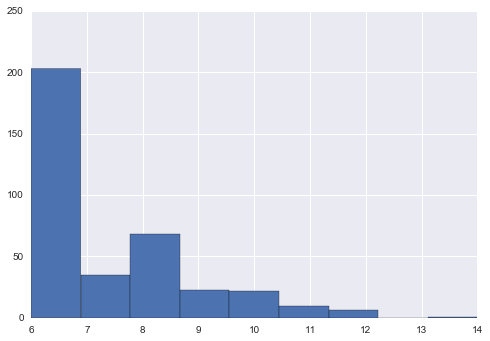

In [412]:
male['Bachelor duration [semesters]'].hist(bins = 9)

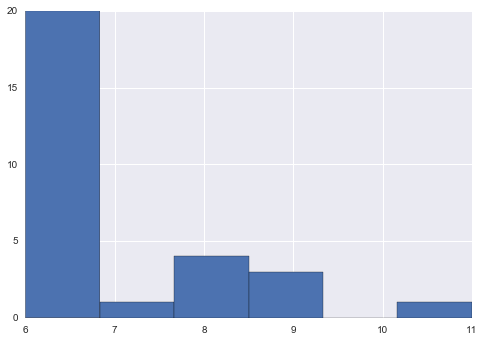

In [414]:
female['Bachelor duration [semesters]'].hist(bins = 6)

# Statistical test and conclusion

We can now execute a statistical test to compare the male and female Bachelor's student at EPFL and determine if there is a significant difference between the two group.

Since we have two independant groups of sample, we chose to use Two-Sample T-Test. 

In [422]:
stats.ttest_ind(a= male['Bachelor duration [semesters]'],
                b= female['Bachelor duration [semesters]'],
                equal_var=True) #We use student TS T-test, because variance should be equal

Ttest_indResult(statistic=1.1743739616350912, pvalue=0.24095278708853646)

The two-tailed p-value is 0.24, which way above the standard thresholds. This implies that we cannot reject the null hypothesis. 

Even if the female student seems at the first sight to finish their Bachelor significantly faster than male student (6.79 vs 7.15 semesters), the low number of female student in the data (29, vs 368 for male student) combined with the relatively high standard deviation (1,34 and 1,57 for female and male respectively) explains this high p-value.

**There is therefore no significant statistical difference according to gender**